In [39]:
import keras
import numpy as np
import pandas as pd
import nltk
import seaborn as sn
import matplotlib.pyplot as plt
import language_tool_python
import scipy.stats as stats

tool = language_tool_python.LanguageTool('en-US')
is_bad_rule = lambda rule: rule.message == 'Possible spelling mistake found.' and len(rule.replacements) and \
                           rule.replacements[0][0].isupper()

## Transfer key_times.csv (external project) into same format of fixed_text_typing_dataset.csv (emotion recognition)

In [40]:
import pandas as pd

# Read the CSV
df = pd.read_csv('keystrokes_reader_project/key_times.csv')

# Replace specific key values with desired characters
df['key'] = df['key'].replace({'Key.space': ' ', 'Key.backspace': '\b', 'Key.enter': '\n'})

# Initialize new DataFrame with the required columns
new_df_columns = ['userId', 'emotionIndex', 'index', 'keyCode', 'keyDown', 'keyUp', 'D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2', 'D1U3', 'D1D3', 'answer']
new_df = pd.DataFrame(columns=new_df_columns)

# Loop through each row to calculate time differences
for i, row in df.iterrows():
    keyCode = row['key']
    keyDown = row['down']
    keyUp = row['up']
    D1U1 = keyUp - keyDown  # Always calculable

    # Initialize placeholders
    D1U2 = D1D2 = U1D2 = U1U2 = D1U3 = D1D3 = None

    # Calculate D1U2, D1D2, U1D2, U1U2 if not the last row
    if i < len(df) - 1:
        next_row = df.iloc[i + 1]
        D1U2 = next_row['up'] - keyDown
        D1D2 = next_row['down'] - keyDown
        U1D2 = next_row['down'] - keyUp
        U1U2 = next_row['up'] - keyUp

    # Calculate D1D3, D1U3 if there are at least two more keys ahead
    if i < len(df) - 2:
        after_next_row = df.iloc[i + 2]
        D1D3 = after_next_row['down'] - keyDown
        D1U3 = after_next_row['up'] - keyDown

    # Append row to new DataFrame
    new_row = {
        'userId': 100, 'emotionIndex': 'N', 'index': i, 'keyCode': keyCode,
        'keyDown': keyDown, 'keyUp': keyUp, 'D1U1': D1U1, 'D1U2': D1U2,
        'D1D2': D1D2, 'U1D2': U1D2, 'U1U2': U1U2, 'D1U3': D1U3, 'D1D3': D1D3,
        'answer': None
    }
    new_df = new_df.append(new_row, ignore_index=True)

# Export to CSV
new_df.to_csv('keystrokes_reader_project/extended_fixed_key_times.csv', index=False)

## Data importation

In [41]:
df_fixed = pd.read_csv('data/fixed_text_typing_dataset.csv', sep=';')
df_freq = pd.read_csv('data/frequency_dataset.csv', sep=';')
df_user = pd.read_csv('data/participants_information.csv', sep=';')

df_freq = df_freq.rename(columns={'User ID': 'userId'})

## Sentences reconstruction and feature extraction

In [42]:
# reconstruct users' sentences from the keycode in df_fixed

sentence = ''
uppercase = False
uppercase_tmp = False
i_start = 0
i_end = 0
text_fixed = pd.DataFrame(columns=['sentence', 'idx_start', 'idx_end'])

df_fixed.keyCode = df_fixed.keyCode.astype(str)

for i in range(len(df_fixed)):
    if i > 0 and (df_fixed.userId[i] != df_fixed.userId[i - 1] or df_fixed.emotionIndex[i] != df_fixed.emotionIndex[
        i - 1]):  #df_fixed._id[i][:-2] != df_fixed._id[i-1][:-2]:
        i_end = i - 1
        if len(text_fixed) == 62:
            ids_start = [i for i in range(len(sentence)) if sentence[i:i + 4] == 'once']
            text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start, i_start + ids_start[1] - 1]],
                                                        columns=['sentence', 'idx_start', 'idx_end']),
                                           ignore_index=True)
            text_fixed = text_fixed.append(
                pd.DataFrame([[sentence, i_start + ids_start[1], i_start + ids_start[2] - 1]],
                             columns=['sentence', 'idx_start', 'idx_end']), ignore_index=True)
            text_fixed = text_fixed.append(
                pd.DataFrame([[sentence, i_start + ids_start[2], i_end]], columns=['sentence', 'idx_start', 'idx_end']),
                ignore_index=True)
        elif len(text_fixed) == 134 or len(text_fixed) == 190:
            ids_start = [i for i in range(len(sentence)) if sentence[i:i + 4] == 'Once']
            text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start, i_start + ids_start[1] - 1]],
                                                        columns=['sentence', 'idx_start', 'idx_end']),
                                           ignore_index=True)
            text_fixed = text_fixed.append(
                pd.DataFrame([[sentence, i_start + ids_start[1], i_end]], columns=['sentence', 'idx_start', 'idx_end']),
                ignore_index=True)
        else:
            if sentence[0].islower() and sentence[1].isupper():
                sentence = sentence.swapcase()
            text_fixed = text_fixed.append(
                pd.DataFrame([[sentence, i_start, i_end]], columns=['sentence', 'idx_start', 'idx_end']),
                ignore_index=True)
        i_start = i
        sentence = ''
        uppercase = False
        uppercase_tmp = False
    if df_fixed.keyCode[i] == '\\b':  # delete key
        sentence = sentence[:max(0, len(sentence) - 1)]
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '\\u0014':  # caps lock key
        uppercase = not uppercase
        continue
    if df_fixed.keyCode[i] == '\\u0010' and not uppercase:  # shift key
        uppercase_tmp = True
        continue
    if df_fixed.keyCode[i] == '¼':  # comma key
        sentence += ','
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == 'ß':  # exclamation mark key
        sentence += '!'
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '¾':  # dot key
        sentence += '.'
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '4    ':  # apostrophe key
        sentence += "'"
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '6    ':  # dash key
        sentence += "-"
        uppercase_tmp = False
        continue
    if df_fixed.keyCode[i] == '¿':  # colon key
        sentence += ":"
        uppercase_tmp = False
        continue
    if uppercase:
        sentence += df_fixed.keyCode[i].upper()
        continue
    if uppercase_tmp:
        sentence += df_fixed.keyCode[i].upper()
        uppercase_tmp = False
        continue
    sentence += df_fixed.keyCode[i]

text_fixed = text_fixed.append(pd.DataFrame([[sentence, i_start, i]], columns=['sentence', 'idx_start', 'idx_end']),
                               ignore_index=True)

### Fixed text

In [43]:
# fixed text that users have been asked to write

gold_fixed = {
    'N': 'Once there was a cat and a mouse. Usually, cats eat mice, and mice run away from cats. But this cat and this mouse liked each other very much. They liked each other so much that they lived together.',
    'H': 'We can not help falling in love with cute and funny babies. Their beautiful and joyful laughter makes us happy.',
    'C': 'Beautiful nature and calm music are always relaxing. The soft sounds are so pleasant to listen to. Watching the superb nature calms our body and soul.',
    'S': 'The boy yells at his father to wake him up. But the father is dead. The poor boy is very sad. He realized that his father is gone forever.',
    'A': 'Jake has a horrible temper, especially when he drinks alcohol. He gets andgry and agressive when he is drunk. He savagely  beats and violeates his wife.'
}

In [44]:
# functions to extract features from the df_fixed table
df_fixed = df_fixed.drop(['D1U3', 'D1D3'], axis=1)
df_fixed.head()

,userId,emotionIndex,index,keyCode,keyDown,keyUp,D1U1,D1U2,D1D2,U1D2,U1U2,answer
0,100,N,3448,o,"1,58E+12","1,58E+12",90,2556,2479.0,2389,2466,NaN
1,100,N,3449,n,"1,58E+12","1,58E+12",77,258,131.0,54,181,NaN
2,100,N,3450,c,"1,58E+12","1,58E+12",127,613,519.0,392,486,NaN
3,100,N,3451,e,"1,58E+12","1,58E+12",94,276,200.0,106,182,NaN
4,100,N,3452,,"1,58E+12","1,58E+12",76,2104,2032.0,1956,2028,NaN


In [45]:
def extract_editDistance_fixed(gold_fixed, emotion, sentence):
    return nltk.edit_distance(sentence, gold_fixed[emotion])

#this method is used to calculate the edit distance between two strings
#the edit distance is the number of characters that need to be substituted, inserted, or deleted, to transform one string into another


def extract_nbKeystroke(val, start, end):
    return val[end] - val[start] + 1

#this method is used to calculate the number of keystrokes


def extract_mean(val, start, end):
    return np.mean(val[start:end + 1])
#this method is used to calculate the mean of the values

def extract_std(val, start, end):
    return np.std(val[start:end + 1])
#this method is used to calculate the standard deviation of the values

def extract_answer(val, start, end):
    for i in range(start, end + 1):
        if val[i] != np.nan:
            return val[i]
    return np.nan
#this method is used to extract the answer from the values

In [46]:
# key_features = ['D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2']
# 
# text_fixed['userId'] = df_fixed.userId[text_fixed.idx_start].values
# text_fixed['emotionIndex'] = df_fixed.emotionIndex[text_fixed.idx_start].values
# text_fixed = text_fixed.reindex(columns=['idx_start', 'idx_end', 'userId', 'emotionIndex', 'sentence'])
# text_fixed['editDistance'] = text_fixed.apply(
#     lambda x: extract_editDistance_fixed(gold_fixed, x['emotionIndex'], x['sentence']), axis=1)
# text_fixed['nbKeystroke'] = text_fixed.apply(
#     lambda x: extract_nbKeystroke(df_fixed.index, x['idx_start'], x['idx_end']), axis=1)
# text_fixed['answer'] = text_fixed.apply(lambda x: extract_answer(df_fixed.answer, x['idx_start'], x['idx_end']), axis=1)
# 
# for feat in key_features:
#     df_fixed[feat] = df_fixed[feat].apply(lambda x: np.nan if np.abs(x) > 1570000000000 else x)
#     text_fixed[feat + '_mean'] = text_fixed.apply(lambda x: extract_mean(df_fixed[feat], x['idx_start'], x['idx_end']),
#                                                   axis=1)
#     text_fixed[feat + '_std'] = text_fixed.apply(lambda x: extract_std(df_fixed[feat], x['idx_start'], x['idx_end']),
#                                                  axis=1)
# 
# text_fixed.head()


# altered due to ufunc error: UFuncTypeError: ufunc 'absolute' did not contain a loop with signature matching types <class 'numpy.dtypes.StrDType'> -> None

# Convert the key features columns to numeric, setting errors='coerce' to convert non-numeric values to NaN

key_features = ['D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2']

for feat in key_features:
    df_fixed[feat] = pd.to_numeric(df_fixed[feat], errors='coerce')

    # Rest of your code
text_fixed['userId'] = df_fixed.userId[text_fixed.idx_start].values
text_fixed['emotionIndex'] = df_fixed.emotionIndex[text_fixed.idx_start].values
text_fixed = text_fixed.reindex(columns=['idx_start', 'idx_end', 'userId', 'emotionIndex', 'sentence'])
text_fixed['editDistance'] = text_fixed.apply(
    lambda x: extract_editDistance_fixed(gold_fixed, x['emotionIndex'], x['sentence']), axis=1)
text_fixed['nbKeystroke'] = text_fixed.apply(
    lambda x: extract_nbKeystroke(df_fixed.index, x['idx_start'], x['idx_end']), axis=1)
text_fixed['answer'] = text_fixed.apply(lambda x: extract_answer(df_fixed.answer, x['idx_start'], x['idx_end']), axis=1)

# Apply the lambda function
for feat in key_features:
    df_fixed[feat] = df_fixed[feat].apply(lambda x: np.nan if np.abs(x) > 1570000000000 else x)
    text_fixed[feat + '_mean'] = text_fixed.apply(lambda x: extract_mean(df_fixed[feat], x['idx_start'], x['idx_end']),
                                                  axis=1)
    text_fixed[feat + '_std'] = text_fixed.apply(lambda x: extract_std(df_fixed[feat], x['idx_start'], x['idx_end']),
                                                 axis=1)

text_fixed.head()



,idx_start,idx_end,userId,emotionIndex,sentence,editDistance,nbKeystroke,answer,D1U1_mean,D1U1_std,D1U2_mean,D1U2_std,D1D2_mean,D1D2_std,U1D2_mean,U1D2_std,U1U2_mean,U1U2_std
0,0,282,100,N,"once there was a cat and a mouse. usually , ca...",26,283,NaN,96.074380,31.715592,884.215768,1157.264475,683.060284,1101.553201,694.609959,1157.337134,677.178571,1108.432937
1,283,422,100,H,We can not help falling in love with cute and ...,2,140,R,99.071429,22.182246,813.769784,701.131104,714.784173,699.459223,615.776978,696.222821,714.762590,697.865776
2,423,656,113,N,Once there was a cat and a mouse\u0010. Usaual...,23,234,NaN,88.440171,35.663291,449.802575,381.758170,361.309013,379.970339,272.832618,380.091995,361.326180,381.705475
3,657,840,113,C,Beautiful nature and calm music are always rel...,2,184,R,92.587571,51.886713,526.255682,613.476557,426.710383,601.426508,347.096591,614.503538,421.160221,614.552941
4,841,978,113,H,We can not help falling in love with cute and ...,2,138,R,92.086957,54.058138,443.934307,332.686657,352.138686,325.048838,260.189781,325.204406,351.985401,332.486627


[]

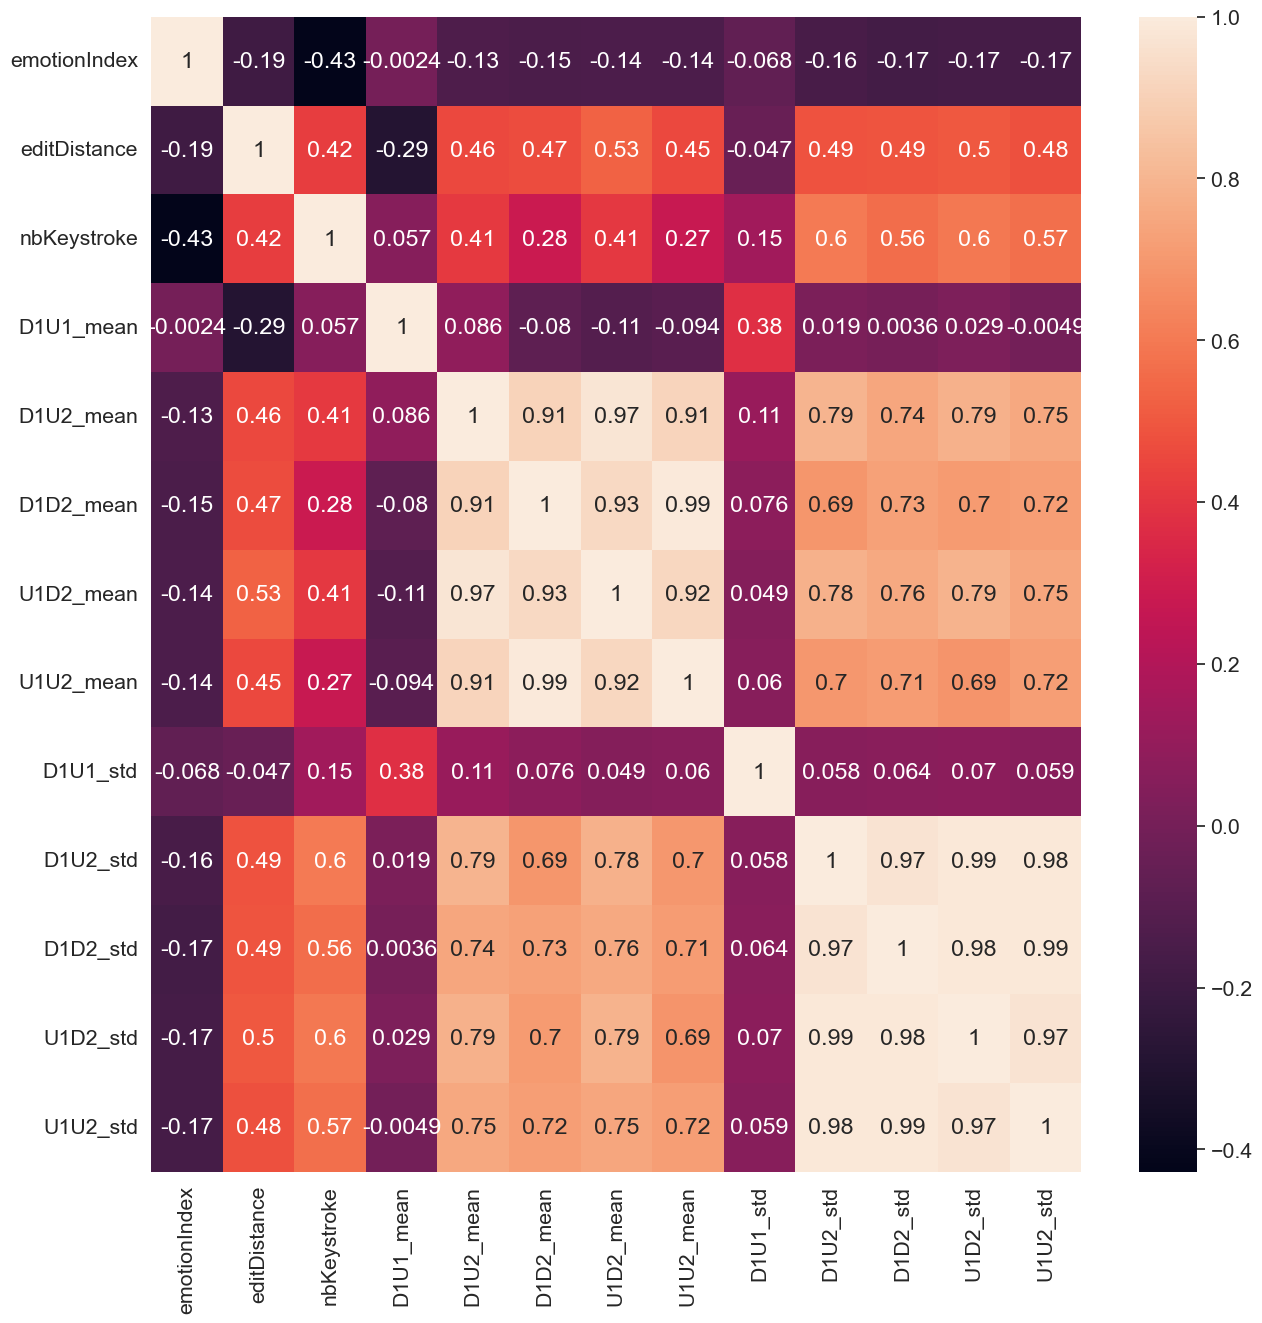

In [47]:
## correlation matrix

# Numeric columns of the dataset
text_fixed.emotionIndex = text_fixed.emotionIndex.map({'N': 0, 'H': 1, 'C': 2, 'S': 3, 'A': 4})
numeric_col = ['emotionIndex', 'editDistance', 'nbKeystroke'] + [col for col in text_fixed.columns if
                                                                 '_mean' in col] + [col for col in text_fixed.columns if
                                                                                    '_std' in col]

# Correlation Matrix formation
corr_matrix = text_fixed.loc[:, numeric_col].corr()
text_fixed.emotionIndex = text_fixed.emotionIndex.map({0: 'N', 1: 'H', 2: 'C', 3: 'S', 4: 'A'})

#Using heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 15))
sn.heatmap(corr_matrix, annot=True)
plt.plot()

## Join tables: text_fixed with df_freq_fixed

In [48]:
# filter fixed-text experiments in df_freq
df_freq_fixed = df_freq[df_freq.textIndex == 'FI'].reset_index(drop=True)
#this method is used to reset the index of the DataFrame

In [49]:
# correction of expections to align df_freq_fixed and text_fixed tables
text_fixed.loc[44, 'userId'] = 94
tmp = text_fixed.loc[30]
text_fixed.loc[30] = text_fixed.loc[31]
text_fixed.loc[31] = tmp

In [50]:
# alignment of df_freq_fixed and text_fixed tables
text_fixed['text_index'] = -1
df_freq_fixed['text_index'] = -1
index = 0

i = 0
j = 0
while i < len(df_freq_fixed) and j < len(text_fixed):
    if df_freq_fixed.userId[i] == text_fixed.userId[j] and df_freq_fixed.emotionIndex[i] == text_fixed.emotionIndex[j]:
        df_freq_fixed.loc[i, 'text_index'] = index
        text_fixed.loc[j, 'text_index'] = index
        index += 1
        i += 1
        j += 1
    elif j != len(text_fixed) - 1 and df_freq_fixed.userId[i] == text_fixed.userId[j + 1] and \
            df_freq_fixed.emotionIndex[i] == text_fixed.emotionIndex[j + 1]:
        df_freq_fixed.loc[i, 'text_index'] = index
        text_fixed.loc[j + 1, 'text_index'] = index
        index += 1
        i += 1
        j += 2
    elif i != len(df_freq_fixed) - 1 and df_freq_fixed.userId[i + 1] == text_fixed.userId[j] and \
            df_freq_fixed.emotionIndex[i + 1] == text_fixed.emotionIndex[j]:
        df_freq_fixed.loc[i + 1, 'text_index'] = index
        text_fixed.loc[j, 'text_index'] = index
        index += 1
        i += 2
        j += 1
    else:
        i += 1
        j += 1

In [51]:
# correction of expections to align df_freq_fixed and df_user tables
tmp = df_user.loc[92]
df_user.loc[92] = df_user.loc[91]
df_user.loc[91] = tmp

In [52]:
## alignment of df_freq_index and df_user tables
df_freq_fixed['user_index'] = -1
index = 0

j = 0
for i in range(len(df_freq_fixed)):
    if i in [39, 59, 71, 145, 156, 159, 179, 235]:
        j += 1
    if j < len(df_user) and df_freq_fixed.userId[i] == df_user.userId[j]:
        df_freq_fixed.loc[i, 'user_index'] = j
        i += 1
    else:
        if j < len(df_user) - 1 and df_freq_fixed.userId[i] == df_user.userId[j + 1]:
            df_freq_fixed.loc[i, 'user_index'] = j + 1
            i += 1
            j += 1
        else:
            for k in range(1, 6):
                if df_freq_fixed.userId[i] == df_freq_fixed.userId[i - k]:
                    df_freq_fixed.loc[i, 'user_index'] = df_freq_fixed.loc[i - k, 'user_index']
                    break

In [53]:
# merge all tables
df_fixed_all = df_freq_fixed.join(text_fixed, on='text_index', how='left', rsuffix='_right')
df_fixed_all = df_fixed_all.drop(['userId_right', 'emotionIndex_right', 'text_index_right'], axis=1)
df_fixed_all = df_fixed_all.join(df_user.reset_index().rename(columns={'index': 'user_index'}), on='user_index',
                                 how='left', rsuffix='_right')
df_fixed_all = df_fixed_all.drop(['user_index_right', 'userId_right'], axis=1)
df_fixed_all.head()

#df_fixed_all is the final DataFrame that contains all the information, that was built by joining the tables df_freq_fixed, text_fixed and df_user by using indexes that suit the sentences that were answered by the users

,userId,textIndex,emotionIndex,delFreq,leftFreq,TotTime,text_index,user_index,idx_start,idx_end,...,U1U2_mean,U1U2_std,typeWith,typistType,pcTimeAverage,ageRange,gender,status,degree,country
0,100,FI,N,8,1,192762.0,0,0,0,282,...,677.178571,1108.432937,2 hands,Touch Typist,More than 3 hours per day,16-19,Female,Student,College/University,Tunisia
1,100,FI,H,11,0,99463.0,1,0,283,422,...,714.762590,697.865776,2 hands,Touch Typist,More than 3 hours per day,16-19,Female,Student,College/University,Tunisia
2,113,FI,N,10,0,84265.0,2,1,423,656,...,361.326180,381.705475,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia
3,113,FI,C,7,0,78186.0,3,1,657,840,...,421.160221,614.552941,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia
4,113,FI,H,9,0,48354.0,4,1,841,978,...,351.985401,332.486627,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia


## Data analysis

### Useful functions

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics, model_selection
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import shap
from tqdm import trange

In [55]:
# Receiving a dictionary of performance metrics and printing them
def show_metrics(performance_metrics):
    for metric_name, metric in performance_metrics.items():
        if metric_name.startswith("Confusion"):
            print("Confusion Matrix: ")
            if len(metric) != 5:
                print(pd.DataFrame(metric))
            else:
                print(pd.DataFrame(metric,
                                   index=list(label_dictionary.values()),
                                   columns=list(label_dictionary.values())))
        else:
            print("Metric : % s, Score : % 5.2f" % (metric_name, metric))

In [56]:
# Plotting the Confusion Matrix as a heatmap
label_dictionary = {1: 'N', 2: 'H', 3: 'C', 4: 'S', 5: 'A'}

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pickle
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the plot_confusion_matrix function
def plot_confusion_matrix(confusion_matrix, filename):
    if len(confusion_matrix) != 5:
        df_cm = pd.DataFrame(confusion_matrix)
    else:
        df_cm = pd.DataFrame(confusion_matrix,
                             index=[i for i in label_dictionary.values()],
                             columns=[i for i in label_dictionary.values()])
    plt.figure()
    sn.set(font_scale=1.4)  # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues")
    plt.savefig(filename)
    plt.close()

In [57]:
# Computing the different Performance Metrics
def compute_metrics(clf, dataX, dataY, show=False):
    def performance_measures(y_true, y_pred):
        cnf_matrix = metrics.confusion_matrix(y_true, y_pred, normalize='true')

        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)

        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)

        acc = np.mean((TP + TN) / (TP + FP + FN + TN))
        TP_rate = np.mean(TP / (TP + FN))
        FP_rate = np.mean(FP / (FP + TN))
        precision = np.mean(TP / (TP + FP))
        f_measure = 2 * precision * TP_rate / (precision + TP_rate)
        f_micro = metrics.f1_score(y_true, y_pred, average='micro')
        f_macro = metrics.f1_score(y_true, y_pred, average='macro')

        return (acc, TP_rate, FP_rate, precision, f_measure, f_micro, f_macro,
                np.round(cnf_matrix, 2))

    acc, tp_rate, fp_rate, precision, f_measure, f_micro, f_macro, confusion_matrix = performance_measures(y_true=dataY,
                                                                                                           y_pred=clf.predict(
                                                                                                               dataX))

    performance_metrics = {"ACC": acc, "TP_Rate": tp_rate, "FP_Rate": fp_rate,
                           "Precision": precision, "F_Measure": f_measure, "F_Micro": f_micro, "F_Macro": f_macro,
                           "Confusion Matrix": confusion_matrix}
    if show:
        show_metrics(performance_metrics)

    return performance_metrics, clf

### Data pre-processing

In [58]:
data_fixed = df_fixed_all.loc[:, df_fixed_all.columns.difference(
    ['user_index', 'emotionIndex', 'userId', 'textIndex', 'text_index', 'idx_start', 'idx_end', 'sentence'])]
#loc method is a method that takes only index labels and returns the rows of the dataframe
label_fixed = df_fixed_all.emotionIndex.map({'N': 0, 'H': 1, 'C': 2, 'S': 3, 'A': 4})
# 

In [59]:
# convert categorical features into numerical features
data_fixed.gender = (data_fixed.gender == 'Male')
data_fixed.ageRange = data_fixed.ageRange.map({'16-19': 1, '20-29': 2, '30-39': 3, '>=50': 4})
data_fixed.answer = data_fixed.answer.map({'R': 1, 'W': 0})
data_fixed.degree = data_fixed.degree.map({'High School': 1, 'College/University': 2})
data_fixed.pcTimeAverage = data_fixed.pcTimeAverage.map(
    {'less than an hour per day': 1, 'between 1 hour and 3 hours per day': 2, 'More than 3 hours per day': 3})
data_fixed.status = data_fixed.status.map({'Student': 1, 'Professional': 2})
data_fixed.typeWith = data_fixed.typeWith.map({'1 hand': 1, '2 hands': 2})
data_fixed = pd.get_dummies(data_fixed, columns=['country', 'typistType'])
data_fixed = data_fixed.fillna(-1)
#fillna method (-1) means that the missing values (NaN) are replaced by -1

In [60]:
data_fixed_filter = data_fixed
features = data_fixed_filter.columns.tolist()
print(features)
print(len(features))
#label_fixed = (label_fixed == 1)  ## for binary models

['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std', 'ageRange', 'answer', 'degree', 'delFreq', 'editDistance', 'gender', 'leftFreq', 'nbKeystroke', 'pcTimeAverage', 'status', 'typeWith', 'country_Angola', 'country_Arabie_Saoudite', 'country_Bahamas', 'country_Barbade', 'country_Belgique', 'country_Belize', 'country_Canada', 'country_France', 'country_Germany', 'country_Italy', 'country_Portugal', 'country_Spain', 'country_Suisse', 'country_Tunisia', 'country_United Arab Emirates', 'country_United_States', 'typistType_One Finger Typist', 'typistType_Touch Typist', 'typistType_Two Finger Typist']
41


### Statistical analysis

In [61]:
data_fixed.D1U2_mean.describe()

count     243.000000
mean      527.396707
std       265.232255
min        -1.000000
25%       382.898585
50%       461.966216
75%       577.206529
max      2831.904167
Name: D1U2_mean, dtype: float64

In [62]:
# only for demographic features
# , 'country', 'typistType'

test_columns = ['D1U2_mean', 'D1D2_mean', 'D1D2_mean', 'U1D2_mean']
personal_col = ['typeWith', 'gender', 'ageRange', 'degree', 'pcTimeAverage', 'status']
for column in test_columns:
    for col in personal_col:
        anova = stats.f_oneway(data_fixed.loc[data_fixed[column] < 383, col],
                               data_fixed.loc[(data_fixed[column] >= 383) & (data_fixed[column] < 462), col],
                               data_fixed.loc[(data_fixed[column] >= 462) & (data_fixed[column] < 577), col],
                               data_fixed.loc[data_fixed[column] >= 577, col])
        print(col + ': ' + str(anova))

typeWith: F_onewayResult(statistic=1.0625981968164069, pvalue=0.3656656135760937)
gender: F_onewayResult(statistic=0.756571665449794, pvalue=0.5195069267139663)
ageRange: F_onewayResult(statistic=0.9274717411270018, pvalue=0.4281108442943713)
degree: F_onewayResult(statistic=0.5685627041613412, pvalue=0.6362275327388702)
pcTimeAverage: F_onewayResult(statistic=1.6099404272995905, pvalue=0.1877059793560212)
status: F_onewayResult(statistic=1.999588159091468, pvalue=0.11471258141355706)
typeWith: F_onewayResult(statistic=0.19334546370631087, pvalue=0.9008717295902245)
gender: F_onewayResult(statistic=0.3654624110050236, pvalue=0.7780002578658874)
ageRange: F_onewayResult(statistic=1.33024615974079, pvalue=0.26515452912006854)
degree: F_onewayResult(statistic=0.2681775674212019, pvalue=0.8483045927322145)
pcTimeAverage: F_onewayResult(statistic=1.5907019558837678, pvalue=0.19226733253030542)
status: F_onewayResult(statistic=0.6107938109828985, pvalue=0.6086008444504862)
typeWith: F_oneway

### Multi-class models

In [63]:
#define classification models
classifiers_name = ['LogReg', 'RF', 'XGB', 'SVM', 'MLP']

classifiers = [
    LogisticRegression(multi_class='auto', max_iter=500, solver='newton-cg',
                       class_weight={0: 0.1, 1: 1, 2: 1, 3: 1, 4: 1}),
    RandomForestClassifier(n_estimators=200, max_depth=5, class_weight={0: 0.1, 1: 1, 2: 1, 3: 1, 4: 1}),
    xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False),
    SVC(kernel='rbf', decision_function_shape='ovr', probability=True),  #, class_weight={0:0.1,1:1,2:1,3:1,4:1}),
    MLPClassifier(alpha=1, max_iter=500)]

In [64]:
# comment in afterwards

# micro-F1 scores with a 10-fold cross-validation method

#model_scores_micro = {}
#for i in range(len(classifiers)):
#    model_scores_micro[classifiers_name[i]] = []
#    print(classifiers_name[i])
#    for j in range(10):
#        model = classifiers[i]
#        scores = model_selection.cross_val_score(model, X=data_fixed_filter, y=label_fixed, cv=10, n_jobs=1,
#                                                 scoring='f1_micro')
#        model_scores_micro[classifiers_name[i]] += list(scores)
#    mean = np.nanmean(model_scores_micro[classifiers_name[i]])
#    std = np.nanstd(model_scores_micro[classifiers_name[i]])
#    model_scores_micro[classifiers_name[i]] = [mean, std]

#model_scores_micro

In [65]:
# comment in afterwards

# macro-F1 scores with a 10-fold cross-validation method

#model_scores_macro = {}
#for i in range(len(classifiers)):
#    model_scores_macro[classifiers_name[i]] = []
#    print(classifiers_name[i])
#    for j in range(10):
#        model = classifiers[i]
#        scores = model_selection.cross_val_score(model, X=data_fixed_filter, y=label_fixed, cv=10, n_jobs=1,
#                                                 scoring='f1_macro')
#        model_scores_macro[classifiers_name[i]] += list(scores)
#    mean = np.nanmean(model_scores_macro[classifiers_name[i]])
#    std = np.nanstd(model_scores_macro[classifiers_name[i]])
#    model_scores_macro[classifiers_name[i]] = [mean, std]
#
#model_scores_macro

#### Best multi-class model

### Save Models

In [66]:
#"models.pkl" | "models.pickle"
def save_model_m(path: str, models):
    with open(r"{path}", 'wb') as model_writer:
        model_writer.write(models)


def load_model_m(path: str):
    models: list
    with open(r"{path}", 'rb') as model_reader:
        models = model_reader.read()
    return models

#TODO: also save scaler, may also be added in save model, path and type inlcuded

In [67]:
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler


# Save the model to a file
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)


# Load the model from a file
def load_model(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)


# Method to read a CSV file and predict the emotion
def predict_emotion(csv_file, model_file):
    # Load the model
    model = load_model(model_file)

    # Read the CSV file
    data = pd.read_csv(csv_file)

    # Preprocess the data
    data['typeWith'] = data['typeWith'].map({'1 hand': 1, '2 hands': 2})
    data['gender'] = (data['gender'] == 'Male')
    data['ageRange'] = data['ageRange'].map({'16-19': 1, '20-29': 2, '30-39': 3, '>=50': 4})
    data['degree'] = data['degree'].map({'High School': 1, 'College/University': 2})
    data['pcTimeAverage'] = data['pcTimeAverage'].map(
        {'less than an hour per day': 1, 'between 1 hour and 3 hours per day': 2, 'More than 3 hours per day': 3})
    data['status'] = data['status'].map({'Student': 1, 'Professional': 2})

    # Convert 'country' and 'typistType' columns if they exist
    if 'country' in data.columns and 'typistType' in data.columns:
        data = pd.get_dummies(data, columns=['country', 'typistType'])

    data = data.fillna(-1)

    # Scale the data
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Predict the emotion
    print(type(model))
    predictions = model.predict_proba(data)

    return predictions

In [68]:
import matplotlib.pyplot as plt

def save_feature_importance_plot(feature_importance, filename, title):
    plt.figure(figsize=(10, 6))
    feature_importance.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()  # Adjust the layout to prevent cutting off parts of the plot
    plt.savefig(filename)
    plt.close()

In [69]:
def iterate_all_models(model_name):
    X_train, X_test, Y_train, Y_test = train_test_split(data_fixed_filter, label_fixed, test_size=0.2)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = classifiers[classifiers_name.index(model_name)]
    model.fit(X_train, Y_train)

    save_model(model, f'{model_name}.pkl')

    performance_metrics, trained_model = compute_metrics(model, X_test, Y_test, show=True)
    plot_confusion_matrix(performance_metrics["Confusion Matrix"], f'cf_fixed_{model_name}.pdf')

    # Feature importance
    result = permutation_importance(trained_model, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2)
    feature_importance = pd.Series(result.importances_mean, index=data_fixed_filter.columns)
    feature_importance.sort_values(ascending=False, inplace=True)

    save_feature_importance_plot(feature_importance, f'fip_fixed_{model_name}.pdf', f'Feature Importance for {model_name}')

def iterate_all_models_only_keyfeatures(model_name):
    key_features = ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std']

    data_keys = data_fixed_filter[key_features]

    X_train, X_test, Y_train, Y_test = train_test_split(data_keys, label_fixed, test_size=0.2)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = classifiers[classifiers_name.index(model_name)]
    model.fit(X_train_scaled, Y_train)

    save_model(model, f'{model_name}_keyfeatures.pkl')

    performance_metrics, trained_model = compute_metrics(model, X_test_scaled, Y_test, show=True)
    plot_confusion_matrix(performance_metrics["Confusion Matrix"], f'cf_fixed_{model_name}_keyfeatures.pdf')

    # Feature importance
    result = permutation_importance(trained_model, X_test_scaled, Y_test, n_repeats=10, random_state=42, n_jobs=2)
    feature_importance = pd.Series(result.importances_mean, index=key_features)
    feature_importance.sort_values(ascending=False, inplace=True)

    save_feature_importance_plot(feature_importance, f'fip_fixed_{model_name}_keyfeatures.pdf', f'Feature Importance for {model_name} (Key Features)')

C:\Users\dekassla\AppData\Local\Temp\ipykernel_18968\3803814231.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


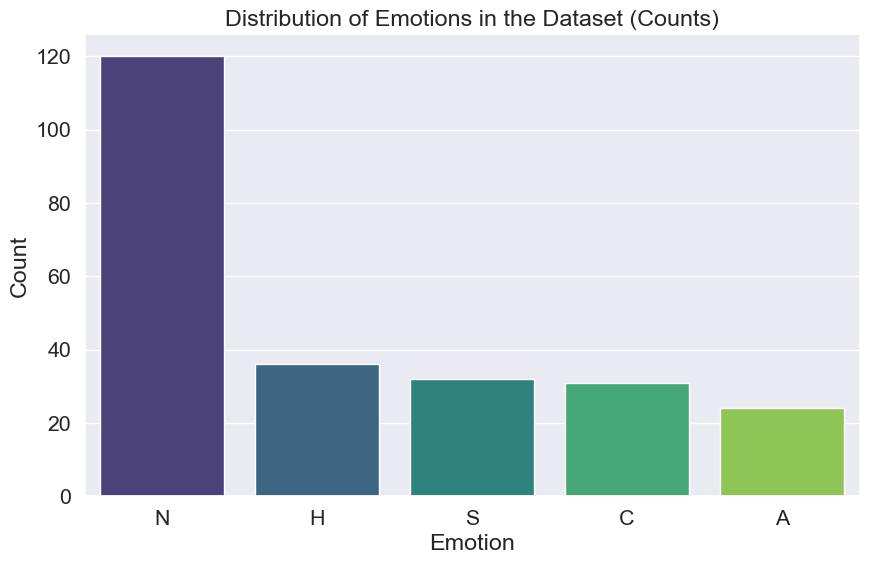

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_fixed_all is your DataFrame and 'emotionIndex' is the column with emotions
emotion_counts = df_fixed_all['emotionIndex'].value_counts()

# Plot the distribution of emotions (counts)
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.title('Distribution of Emotions in the Dataset (Counts)')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.savefig('emotion_distribution_counts.pdf')
plt.show()

C:\Users\dekassla\AppData\Local\Temp\ipykernel_18968\3551042765.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_percentages.index, y=emotion_percentages.values, palette='viridis')


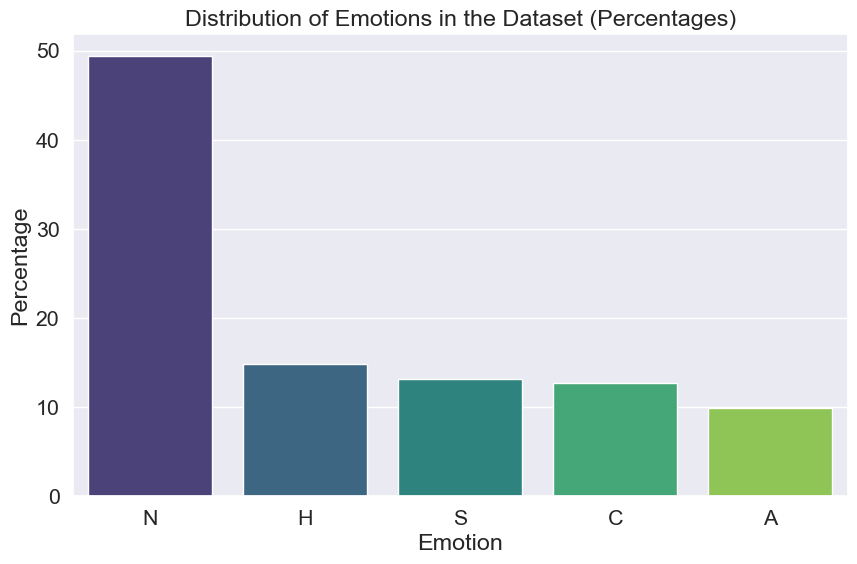

In [71]:
# Calculate the percentage of each emotion
emotion_percentages = (emotion_counts / emotion_counts.sum()) * 100

# Plot the distribution of emotions (percentages)
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_percentages.index, y=emotion_percentages.values, palette='viridis')
plt.title('Distribution of Emotions in the Dataset (Percentages)')
plt.xlabel('Emotion')
plt.ylabel('Percentage')
plt.savefig('emotion_distribution_percentages.pdf')
plt.show()

In [72]:
# run all probabilities

model_names = ['LogReg', 'RF', 'XGB', 'SVM', 'MLP']

for model_name in model_names:
    print("For model: ", model_name, " matrix is:")
    iterate_all_models(model_name)
    iterate_all_models_only_keyfeatures(model_name)

For model:  LogReg  matrix is:
Metric : ACC, Score :  0.71
Metric : TP_Rate, Score :  0.28
Metric : FP_Rate, Score :  0.18
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.14
Metric : F_Macro, Score :  0.16
Confusion Matrix: 
     N     H     C     S     A
N  0.0  0.25  0.29  0.32  0.14
H  0.0  0.29  0.00  0.57  0.14
C  0.0  0.33  0.17  0.33  0.17
S  0.0  0.20  0.20  0.60  0.00
A  0.0  0.33  0.33  0.00  0.33


D:\Coding_Projects\erkd_schieben\erkd\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\dekassla\AppData\Local\Temp\ipykernel_18968\2373644635.py:19: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))
D:\Coding_Projects\erkd_schieben\erkd\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\dekassla\AppData\Local\Temp\ipykernel_18968\2373644635.py:19: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


Metric : ACC, Score :  0.68
Metric : TP_Rate, Score :  0.20
Metric : FP_Rate, Score :  0.20
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.16
Metric : F_Macro, Score :  0.12
Confusion Matrix: 
     N     H     C     S    A
N  0.0  0.61  0.26  0.13  0.0
H  0.0  0.62  0.25  0.12  0.0
C  0.0  0.20  0.00  0.80  0.0
S  0.0  0.38  0.25  0.38  0.0
A  0.0  0.60  0.20  0.20  0.0
For model:  RF  matrix is:
Metric : ACC, Score :  0.79
Metric : TP_Rate, Score :  0.47
Metric : FP_Rate, Score :  0.13
Metric : Precision, Score :  0.48
Metric : F_Measure, Score :  0.48
Metric : F_Micro, Score :  0.43
Metric : F_Macro, Score :  0.41
Confusion Matrix: 
      N     H     C     S     A
N  0.38  0.17  0.21  0.17  0.08
H  0.25  0.50  0.00  0.00  0.25
C  0.12  0.00  0.50  0.25  0.12
S  0.12  0.38  0.00  0.38  0.12
A  0.20  0.00  0.00  0.20  0.60
Metric : ACC, Score :  0.71
Metric : TP_Rate, Score :  0.27
Metric : FP_Rate, Score :  0.18
Metric : Precision, Sco

C:\Users\dekassla\AppData\Local\Temp\ipykernel_18968\2373644635.py:19: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


Metric : ACC, Score :  0.74
Metric : TP_Rate, Score :  0.36
Metric : FP_Rate, Score :  0.16
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.63
Metric : F_Macro, Score :  0.37
Confusion Matrix: 
      N     H     C     S    A
N  0.83  0.00  0.14  0.03  0.0
H  0.38  0.62  0.00  0.00  0.0
C  0.60  0.40  0.00  0.00  0.0
S  0.50  0.00  0.17  0.33  0.0
A  0.00  0.00  0.00  1.00  0.0
For model:  SVM  matrix is:
Metric : ACC, Score :  0.68
Metric : TP_Rate, Score :  0.20
Metric : FP_Rate, Score :  0.20
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.51
Metric : F_Macro, Score :  0.14
Confusion Matrix: 
     N    H    C    S    A
N  1.0  0.0  0.0  0.0  0.0
H  1.0  0.0  0.0  0.0  0.0
C  1.0  0.0  0.0  0.0  0.0
S  1.0  0.0  0.0  0.0  0.0
A  1.0  0.0  0.0  0.0  0.0


C:\Users\dekassla\AppData\Local\Temp\ipykernel_18968\2373644635.py:19: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))
C:\Users\dekassla\AppData\Local\Temp\ipykernel_18968\2373644635.py:19: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


Metric : ACC, Score :  0.68
Metric : TP_Rate, Score :  0.20
Metric : FP_Rate, Score :  0.20
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.51
Metric : F_Macro, Score :  0.14
Confusion Matrix: 
     N    H    C    S    A
N  1.0  0.0  0.0  0.0  0.0
H  1.0  0.0  0.0  0.0  0.0
C  1.0  0.0  0.0  0.0  0.0
S  1.0  0.0  0.0  0.0  0.0
A  1.0  0.0  0.0  0.0  0.0
For model:  MLP  matrix is:


D:\Coding_Projects\erkd_schieben\erkd\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dekassla\AppData\Local\Temp\ipykernel_18968\2373644635.py:19: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


Metric : ACC, Score :  0.68
Metric : TP_Rate, Score :  0.20
Metric : FP_Rate, Score :  0.20
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.53
Metric : F_Macro, Score :  0.18
Confusion Matrix: 
      N     H     C    S     A
N  0.86  0.00  0.07  0.0  0.07
H  0.88  0.12  0.00  0.0  0.00
C  1.00  0.00  0.00  0.0  0.00
S  0.83  0.17  0.00  0.0  0.00
A  0.50  0.25  0.25  0.0  0.00


C:\Users\dekassla\AppData\Local\Temp\ipykernel_18968\2373644635.py:19: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


Metric : ACC, Score :  0.68
Metric : TP_Rate, Score :  0.20
Metric : FP_Rate, Score :  0.20
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.57
Metric : F_Macro, Score :  0.15
Confusion Matrix: 
     N    H    C    S    A
N  1.0  0.0  0.0  0.0  0.0
H  1.0  0.0  0.0  0.0  0.0
C  1.0  0.0  0.0  0.0  0.0
S  1.0  0.0  0.0  0.0  0.0
A  1.0  0.0  0.0  0.0  0.0


### Binary classification

In [73]:
# initialise more balanced dataframe, to have more equal number of samples for each emotion
import pandas as pd

# Define the emotion mapping
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}

# Calculate the minimum sample size across all emotion categories
min_sample_size = df_fixed_all['emotionIndex'].value_counts().min()

# Sample data for each emotion category
sampled_data = []
for emotion in emotion_mapping.keys():
    emotion_df = df_fixed_all[df_fixed_all['emotionIndex'] == emotion]
    sampled_emotion_df = emotion_df.sample(n=min_sample_size, random_state=42)
    sampled_data.append(sampled_emotion_df)

# Concatenate the sampled data
dataframe_balanced = pd.concat(sampled_data, axis=0)

# Shuffle the resulting DataFrame
dataframe_balanced = dataframe_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows to verify
print(dataframe_balanced.head())

   userId textIndex emotionIndex  delFreq  leftFreq   TotTime  text_index  \
0     164        FI            H        0         0  102126.0          97   
1      58        FI            H        0         0   36777.0          15   
2      25        FI            N        1         0   82270.0          50   
3      99        FI            C        4         0   76312.0         173   
4     138        FI            H        0         0   51046.0         122   

   user_index idx_start idx_end  ...   U1U2_mean    U1U2_std  typeWith  \
0          -1     18853   18966  ...  260.566372  163.874973       NaN   
1           2      2691    2799  ...  339.268519  288.754304   2 hands   
2          26     10203   10403  ...  410.935000  344.718219   2 hands   
3          86     33776   34020  ...  472.329167  549.966503   2 hands   
4          56     23905   24083  ...  500.629213  503.603306   2 hands   

          typistType                       pcTimeAverage  ageRange  gender  \
0             

In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Define the key features
key_features = ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1U2_std']

# Ensure key features are present in dataframe_balanced
missing_features = [feat for feat in key_features if feat not in dataframe_balanced.columns]
if missing_features:
    raise KeyError(f"Missing features in dataframe_balanced: {missing_features}")

# Filter the DataFrame to include only the specified key features
data_keys = dataframe_balanced[key_features]

# One-hot encode the emotions
emotion_one_hot = pd.get_dummies(dataframe_balanced['emotionIndex'])

# Ensure the number of samples in data_keys and emotion_one_hot are the same
if len(data_keys) != len(emotion_one_hot):
    raise ValueError(f"Mismatch in number of samples: data_keys ({len(data_keys)}) and emotion_one_hot ({len(emotion_one_hot)})")

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(data_keys, emotion_one_hot, test_size=0.2)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = keras.models.Sequential()
model.add(layers.Input(shape=(len(key_features),)))
model.add(layers.Dense(int(len(key_features) * 1.5), activation="relu"))
model.add(layers.Dense(int(len(key_features) * 0.8), activation="relu"))
model.add(layers.Dense(int(len(key_features) * 0.5), activation="relu"))
model.add(layers.Dense(emotion_one_hot.shape[1], activation="softmax"))

# Compile the model
model.compile(optimizer=keras.optimizers.SGD(0.01), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train_scaled, Y_train, batch_size=32, epochs=100, validation_data=(X_test_scaled, Y_test))

# Check if the training history is available
print(history.history)

# Predict the test set
Y_pred = model.predict(X_test_scaled)
Y_pred_classes = Y_pred.argmax(axis=1)
Y_test_classes = Y_test.values.argmax(axis=1)

# Confusion Matrix
cm = confusion_matrix(Y_test_classes, Y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_one_hot.columns)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('cf_fixed_ann.pdf')
plt.close()

# Custom scoring function
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    y_pred_classes = y_pred.argmax(axis=1)
    return np.mean(y_pred_classes == y)

# Feature Importance
result = permutation_importance(model, X_test_scaled, Y_test_classes, scoring=custom_scorer, n_repeats=10, random_state=42, n_jobs=2)
feature_importance = pd.Series(result.importances_mean, index=key_features)
feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar', color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig('fip_fixed_ann.pdf')
plt.close()

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.1628 - loss: 1.6143 - val_accuracy: 0.1250 - val_loss: 1.6176
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2253 - loss: 1.6151 - val_accuracy: 0.0833 - val_loss: 1.6179
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2148 - loss: 1.6141 - val_accuracy: 0.0833 - val_loss: 1.6182
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2396 - loss: 1.6093 - val_accuracy: 0.0833 - val_loss: 1.6185
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2630 - loss: 1.6122 - val_accuracy: 0.0417 - val_loss: 1.6188
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2643 - loss: 1.6098 - val_accuracy: 0.0417 - val_loss: 1.6191
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2396 - loss: 1.6112 - val_accuracy: 0.0417 - val_loss: 1.6194
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2448 - loss: 1.6138 - val_accuracy: 0.0417 - val_loss

D:\Coding_Projects\erkd_schieben\erkd\.venv\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the key features
key_features = ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1U2_std']

# Filter out rows with 'emotionNeutral'
dataframe_filtered = dataframe_balanced[dataframe_balanced['emotionIndex'] != 'H' ]

# Ensure key features are present in dataframe_filtered
missing_features = [feat for feat in key_features if feat not in dataframe_filtered.columns]
if missing_features:
    raise KeyError(f"Missing features in dataframe_filtered: {missing_features}")

# Filter the DataFrame to include only the specified key features
data_keys = dataframe_filtered[key_features]

# One-hot encode the emotions
emotion_one_hot = pd.get_dummies(dataframe_filtered['emotionIndex'])

# Ensure the number of samples in data_keys and emotion_one_hot are the same
if len(data_keys) != len(emotion_one_hot):
    raise ValueError(f"Mismatch in number of samples: data_keys ({len(data_keys)}) and emotion_one_hot ({len(emotion_one_hot)})")

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(data_keys, emotion_one_hot, test_size=0.2)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = keras.models.Sequential()
model.add(layers.Input(shape=(len(key_features),)))
model.add(layers.Dense(int(len(key_features) * 1.5), activation="relu"))
model.add(layers.Dense(int(len(key_features) * 0.8), activation="relu"))
model.add(layers.Dense(int(len(key_features) * 0.2), activation="relu"))
model.add(layers.Dense(emotion_one_hot.shape[1], activation="softmax"))

# Compile the model
model.compile(optimizer=keras.optimizers.SGD(0.01), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train_scaled, Y_train, batch_size=32, epochs=100, validation_data=(X_test_scaled, Y_test))

# Check if the training history is available
print(history.history)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.2015 - loss: 1.3901 - val_accuracy: 0.2000 - val_loss: 1.3924
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2566 - loss: 1.3906 - val_accuracy: 0.2000 - val_loss: 1.3914
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2527 - loss: 1.3894 - val_accuracy: 0.2000 - val_loss: 1.3896
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1649 - loss: 1.3879 - val_accuracy: 0.1500 - val_loss: 1.3876
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2146 - loss: 1.3866 - val_accuracy: 0.2000 - val_loss: 1.3872
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1637 - loss: 1.3863 - val_accuracy: 0.2000 - val_loss: 1.3874
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3022 - loss: 1.3861 - val_accuracy: 0.2000 - val_loss: 1.3875
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2512 - loss: 1.3861 - val_accuracy: 0.2000 - val_loss:

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the minimum sample size between male and female
min_sample_size = df_fixed_all['gender'].value_counts().min()

# Sample data for each gender category
male_data = df_fixed_all[df_fixed_all['gender'] == 'Male'].sample(min_sample_size, random_state=42)
female_data = df_fixed_all[df_fixed_all['gender'] == 'Female'].sample(min_sample_size, random_state=42)

# Concatenate the sampled data
dataframe_balanced = pd.concat([male_data, female_data], axis=0)

# Shuffle the resulting DataFrame
dataframe_balanced = dataframe_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows to verify
print(dataframe_balanced.head())

# Define the key features
key_features = ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1U2_std']

# Ensure key features are present in the DataFrame
missing_features = [feat for feat in key_features if feat not in dataframe_balanced.columns]
if missing_features:
    raise KeyError(f"Missing features in dataframe_balanced: {missing_features}")

# Filter the DataFrame to include only the specified key features
data_keys = dataframe_balanced[key_features]

# Clean the DataFrame by filling missing values with the mean of the column
data_keys = data_keys.fillna(data_keys.mean())

# Encode the gender labels as binary values
dataframe_balanced['gender'] = dataframe_balanced['gender'].map({'Female': 0, 'Male': 1})

# Ensure the gender column is present
if 'gender' not in dataframe_balanced.columns:
    raise KeyError("Gender column is missing in dataframe_balanced")

# Handle missing values in the gender column
if dataframe_balanced['gender'].isnull().any():
    dataframe_balanced['gender'] = dataframe_balanced['gender'].fillna(dataframe_balanced['gender'].mode()[0])

# Extract the gender labels
gender_labels = dataframe_balanced['gender']

# Check for and handle any NaN values in gender_labels
if gender_labels.isnull().any():
    raise ValueError("Gender labels contain NaN values. Please clean the data.")

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(data_keys, gender_labels, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = keras.models.Sequential()
model.add(layers.Input(shape=(len(key_features),)))
model.add(layers.Dense(int(len(key_features) * 1.5), activation="relu"))
model.add(layers.Dense(int(len(key_features) * 0.8), activation="relu"))
model.add(layers.Dense(int(len(key_features) * 0.5), activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))  # Use sigmoid for binary classification

# Compile the model
model.compile(optimizer=keras.optimizers.SGD(0.01), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train_scaled, Y_train, batch_size=32, epochs=100, validation_data=(X_test_scaled, Y_test))

# Check if the training history is available
print(history.history)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, Y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Plot and save confusion matrix
def plot_confusion_matrix(model, X_test, Y_test, filename):
    # Predict the gender on the test set
    Y_pred = (model.predict(X_test) > 0.5).astype("int32")

    # Compute the confusion matrix
    cm = confusion_matrix(Y_test, Y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# Save confusion matrix
plot_confusion_matrix(model, X_test_scaled, Y_test, 'cf_fixed_gender_ann.pdf')

# Custom scoring function
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    y_pred_classes = (y_pred > 0.5).astype("int32").flatten()
    return np.mean(y_pred_classes == y)

# Feature Importance
result = permutation_importance(model, X_test_scaled, Y_test, scoring=custom_scorer, n_repeats=10, random_state=42, n_jobs=2)
feature_importance = pd.Series(result.importances_mean, index=key_features)
feature_importance.sort_values(ascending=False, inplace=True)

# Plot and save feature importance
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar', color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig('fip_fixed_gender_ann.pdf')
plt.close()

   userId textIndex emotionIndex  delFreq  leftFreq   TotTime  text_index  \
0      87        FI            C        8         0   53227.0         114   
1     114        FI            S        1         0   46453.0         157   
2      25        FI            N        1         0   82270.0          50   
3      72        FI            N        6         0  125088.0         233   
4     109        FI            N        8         0   80065.0         148   

   user_index idx_start idx_end  ...   U1U2_mean    U1U2_std  typeWith  \
0          54     22567   22713  ...  360.751724  194.664788   2 hands   
1          76     30746   30959  ...  344.934272  363.676745   2 hands   
2          26     10203   10403  ...  410.935000  344.718219   2 hands   
3         116     44982   45180  ...  254.570707  231.913717   2 hands   
4          71     29030   29258  ...  318.929825  256.428052   2 hands   

          typistType                       pcTimeAverage  ageRange  gender  \
0       Touch 

In [77]:
def display_gender_distribution(dataframe):
    gender_counts = dataframe['gender'].value_counts()
    print("Gender Distribution in the Dataset:")
    print(f"Male: {gender_counts.get(1, 0)}")
    print(f"Female: {gender_counts.get(0, 0)}")

# Display gender distribution
display_gender_distribution(dataframe_balanced)

Gender Distribution in the Dataset:
Male: 79
Female: 79


In [78]:
# Calculate the minimum sample size between male and female
min_sample_size = df_fixed_all['gender'].value_counts().min() - 1

# Sample data for each gender category
male_data = df_fixed_all[df_fixed_all['gender'] == 'Male'].sample(min_sample_size, random_state=42)
female_data = df_fixed_all[df_fixed_all['gender'] == 'Female'].sample(min_sample_size, random_state=42)

# Concatenate the sampled data
dataframe_balanced = pd.concat([male_data, female_data], axis=0)

# Shuffle the resulting DataFrame
dataframe_balanced = dataframe_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the number of samples
print("Number of male samples:", len(dataframe_balanced[dataframe_balanced['gender'] == 'Male']))
print("Number of female samples:", len(dataframe_balanced[dataframe_balanced['gender'] == 'Female']))

Number of male samples: 78
Number of female samples: 78


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Define the key features
key_features = ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1U2_std']

# Ensure key features are present in the DataFrame
missing_features = [feat for feat in key_features if feat not in dataframe_balanced.columns]
if missing_features:
    raise KeyError(f"Missing features in dataframe_balanced: {missing_features}")

# Filter the DataFrame to include only the specified key features
data_keys = dataframe_balanced[key_features]

# Clean the DataFrame by filling missing values with the mean of the column
data_keys = data_keys.fillna(data_keys.mean())

# Encode the gender labels as binary values
dataframe_balanced['gender'] = dataframe_balanced['gender'].map({'Female': 0, 'Male': 1})

# Extract the gender labels
gender_labels = dataframe_balanced['gender']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(data_keys, gender_labels, test_size=0.2, random_state=42)

# Verify the number of samples in the training and testing sets
print("Number of samples in training set:", len(X_train))
print("Number of samples in testing set:", len(X_test))
print("Number of male samples in training set:", sum(Y_train))
print("Number of female samples in training set:", len(Y_train) - sum(Y_train))
print("Number of male samples in testing set:", sum(Y_test))
print("Number of female samples in testing set:", len(Y_test) - sum(Y_test))

Number of samples in training set: 124
Number of samples in testing set: 32
Number of male samples in training set: 61
Number of female samples in training set: 63
Number of male samples in testing set: 17
Number of female samples in testing set: 15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Accuracy: 0.50
Number of male samples: 17
Number of female samples: 15


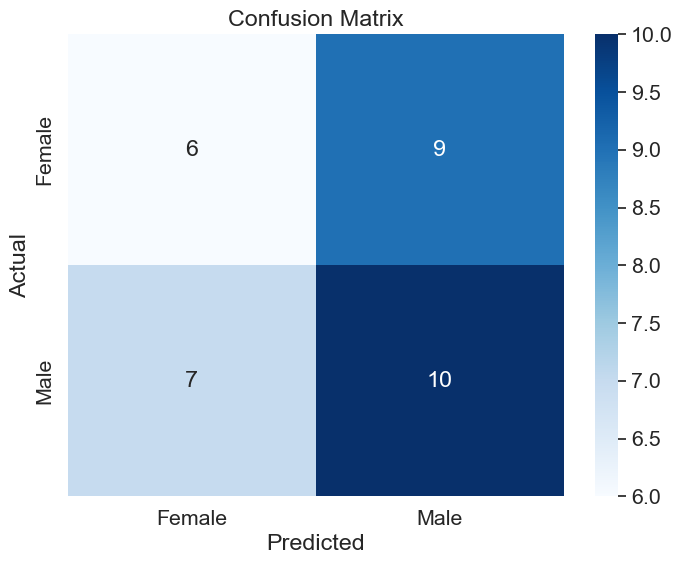

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(model, X_test, Y_test):
    # Predict the gender on the test set
    Y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # Compute the confusion matrix
    cm = confusion_matrix(Y_test, Y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(Y_test, Y_pred)
    
    # Count the number of samples for each gender
    male_count = (Y_test == 1).sum()
    female_count = (Y_test == 0).sum()
    
    # Print accuracy and sample counts
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Number of male samples: {male_count}")
    print(f"Number of female samples: {female_count}")
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Usage
plot_confusion_matrix(model, X_test_scaled, Y_test)

In [81]:
# Handle missing values in the gender column
if dataframe_balanced['gender'].isnull().any():
    # Check if the mode calculation returns a valid result
    gender_mode = dataframe_balanced['gender'].mode()
    if not gender_mode.empty:
        dataframe_balanced['gender'] = dataframe_balanced['gender'].fillna(gender_mode[0])
    else:
        raise ValueError("Cannot fill NaN values in the gender column as the mode calculation failed.")

# Extract the gender labels
gender_labels = dataframe_balanced['gender']

# Check for and handle any NaN values in gender_labels
if gender_labels.isnull().any():
    raise ValueError("Gender labels contain NaN values. Please clean the data.")

# Ensure the gender column is present
if 'gender' not in dataframe_balanced.columns:
    raise KeyError("Gender column is missing in dataframe_balanced")

# Verify the gender column is correctly encoded
if not set(dataframe_balanced['gender'].unique()).issubset({0, 1}):
    raise ValueError("Gender column contains invalid values. Expected binary encoding (0 or 1).")

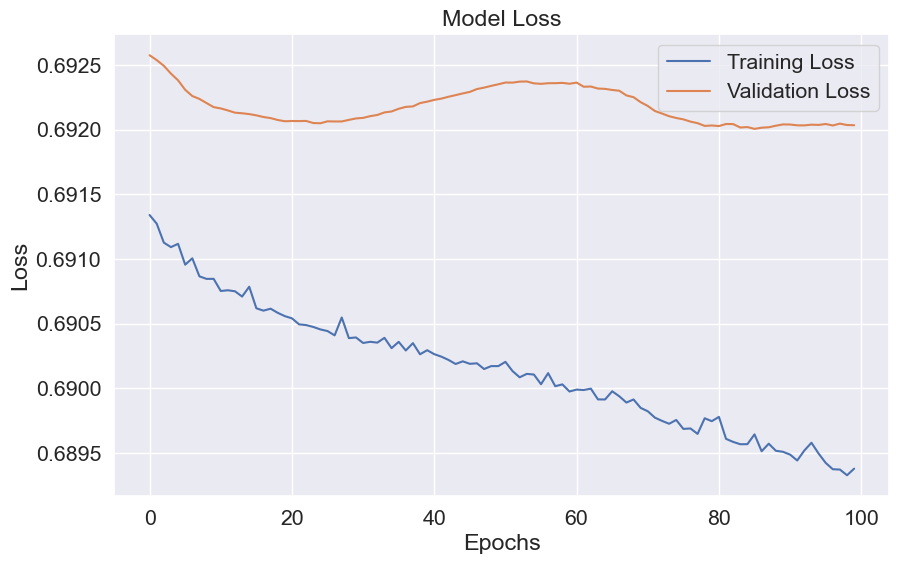

In [82]:
# plot loss

import matplotlib.pyplot as plt

# Extract loss data
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [83]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Copy the DataFrame
df_fixed_all_one_hot = df_fixed_all.copy()

# Check if 'emotionIndex' exists in df_fixed_all
if 'emotionIndex' not in df_fixed_all_one_hot.columns:
    raise KeyError("'emotionIndex' column is missing from df_fixed_all")

# Define the emotion mapping with shorter labels
emotion_mapping = {
    'N': 'N',
    'H': 'H',
    'C': 'C',
    'S': 'S',
    'A': 'A'
}

# Map the emotionIndex to new column names
df_fixed_all_one_hot['emotion'] = df_fixed_all_one_hot['emotionIndex'].map(emotion_mapping)

# One-hot encode the emotions
emotion_one_hot = pd.get_dummies(df_fixed_all_one_hot['emotion'])

# Drop the original emotionIndex and emotion columns
df_fixed_all_one_hot = df_fixed_all_one_hot.drop(['emotionIndex', 'emotion'], axis=1)

# Concatenate the one-hot encoded columns to the original DataFrame
df_fixed_all_one_hot = pd.concat([df_fixed_all_one_hot, emotion_one_hot], axis=1)

# Display the first few rows to verify
print(df_fixed_all_one_hot.head())

label_fixed_one_hot = pd.get_dummies(df_fixed_all_one_hot[emotion_mapping.values()])

# Define the number of input features
key_features = ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std']
input_shape = (len(key_features),)

# Define the number of output classes (emotions)
num_classes = label_fixed_one_hot.shape[1]

# Define the model
model = keras.models.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(layers.Dense(int(input_shape[0] * 1.5), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.8), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.5), activation="relu"))
model.add(layers.Dense(num_classes, activation="softmax"))  # Use softmax for multi-class classification

# Print the model summary
print(model.summary())

# Compile the model
model.compile(optimizer=keras.optimizers.SGD(0.01), loss="categorical_crossentropy", metrics=["accuracy"])

# Filter the DataFrame to include only the specified key features
# Check if key_features exist in data_fixed_filter
print("Columns in data_fixed_filter:", data_fixed_filter.columns.tolist())

# Ensure key_features are present in data_fixed_filter
missing_features = [feat for feat in key_features if feat not in data_fixed_filter.columns]
if missing_features:
    raise KeyError(f"Missing features in data_fixed_filter: {missing_features}")

data_keys = data_fixed_filter[key_features]

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(data_keys, label_fixed_one_hot, test_size=0.2)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
history = model.fit(X_train_scaled, Y_train, batch_size=32, epochs=100, validation_data=(X_test_scaled, Y_test))

# Check if the training history is available
print(history.history)

# Predict the test set
Y_pred = model.predict(X_test_scaled)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test.to_numpy(), axis=1)

# Confusion Matrix
cm = confusion_matrix(Y_test_classes, Y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_mapping.values())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('cf_fixed_ann_unbalanced.pdf')
plt.close()

# Custom scoring function
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return np.mean(y_pred_classes == y)

# Feature Importance
result = permutation_importance(model, X_test_scaled, Y_test_classes, scoring=custom_scorer, n_repeats=10, random_state=42, n_jobs=2)
feature_importance = pd.Series(result.importances_mean, index=key_features)
feature_importance.sort_values(ascending=False, inplace=True)

# Plot and save feature importance
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar', color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig('fip_fixed_ann_unbalanced.pdf')
plt.close()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, Y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

   userId textIndex  delFreq  leftFreq   TotTime  text_index  user_index  \
0     100        FI        8         1  192762.0           0           0   
1     100        FI       11         0   99463.0           1           0   
2     113        FI       10         0   84265.0           2           1   
3     113        FI        7         0   78186.0           3           1   
4     113        FI        9         0   48354.0           4           1   

  idx_start idx_end                                           sentence  ...  \
0         0     282  once there was a cat and a mouse. usually , ca...  ...   
1       283     422  We can not help falling in love with cute and ...  ...   
2       423     656  Once there was a cat and a mouse\u0010. Usaual...  ...   
3       657     840  Beautiful nature and calm music are always rel...  ...   
4       841     978  We can not help falling in love with cute and ...  ...   

   ageRange  gender   status              degree  country  A  C  H  

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 16)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 5)              │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 403 (1.57 KB)

 Trainable params: 403 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

None
Columns in data_fixed_filter: ['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'TotTime', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std', 'ageRange', 'answer', 'degree', 'delFreq', 'editDistance', 'gender', 'leftFreq', 'nbKeystroke', 'pcTimeAverage', 'status', 'typeWith', 'country_Angola', 'country_Arabie_Saoudite', 'country_Bahamas', 'country_Barbade', 'country_Belgique', 'country_Belize', 'country_Canada', 'country_France', 'country_Germany', 'country_Italy', 'country_Portugal', 'country_Spain', 'country_Suisse', 'country_Tunisia', 'country_United Arab Emirates', 'country_United_States', 'typistType_One Finger Typist', 'typistType_Touch Typist', 'typistType_Two Finger Typist']
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4790 - loss: 1.5842 - val_accuracy: 0.4694 - val_loss: 1.5606
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4447 - loss: 1.5729 - val_accuracy: 0.4694 - val_loss: 1.5453
Epoch 3/100
7/7 ━━━━━━━━━━

5 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002044E9D25F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4483 - loss: 1.4495
Test Loss: 1.4219655990600586, Test Accuracy: 0.4693877696990967


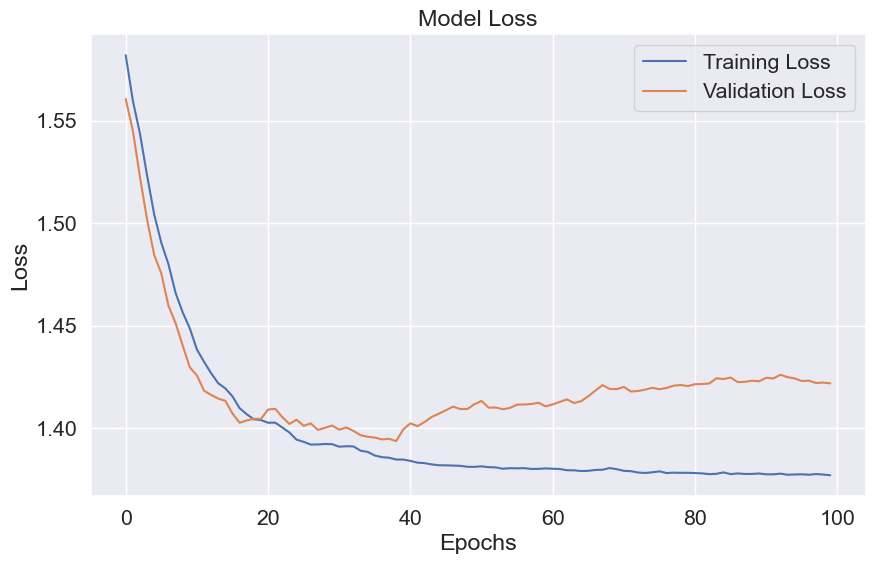

In [84]:
# plot loss

import matplotlib.pyplot as plt

# Extract loss data
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


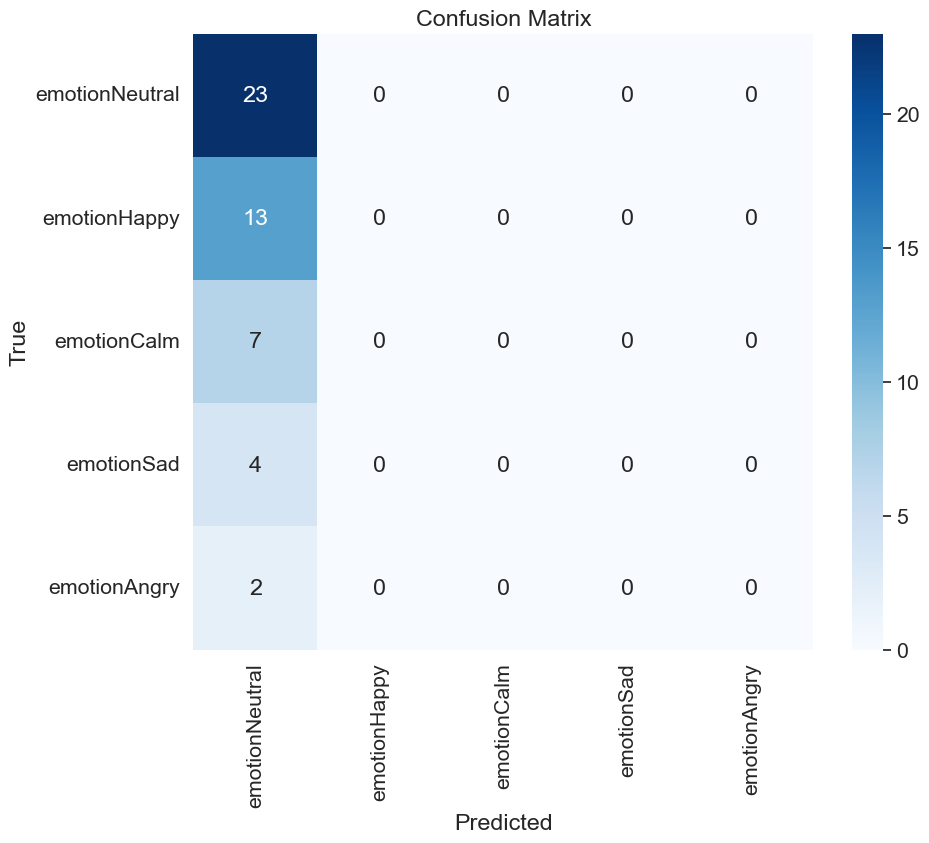

In [85]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict the classes for the test set
Y_pred = model.predict(X_test_scaled)
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert probabilities to class labels

# Ensure Y_test is a 1D array
if Y_test.ndim == 2:
    Y_test_classes = np.argmax(Y_test.to_numpy(), axis=1)  # Convert one-hot encoded DataFrame to class labels
else:
    Y_test_classes = Y_test.to_numpy()

# Generate the confusion matrix
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes)

# Define the emotion mapping
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Class distribution in Y_train:
N    97
H    23
C    24
S    28
A    22
dtype: int64
Class distribution in Y_test:
N    23
H    13
C     7
S     4
A     2
dtype: int64
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Sample predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


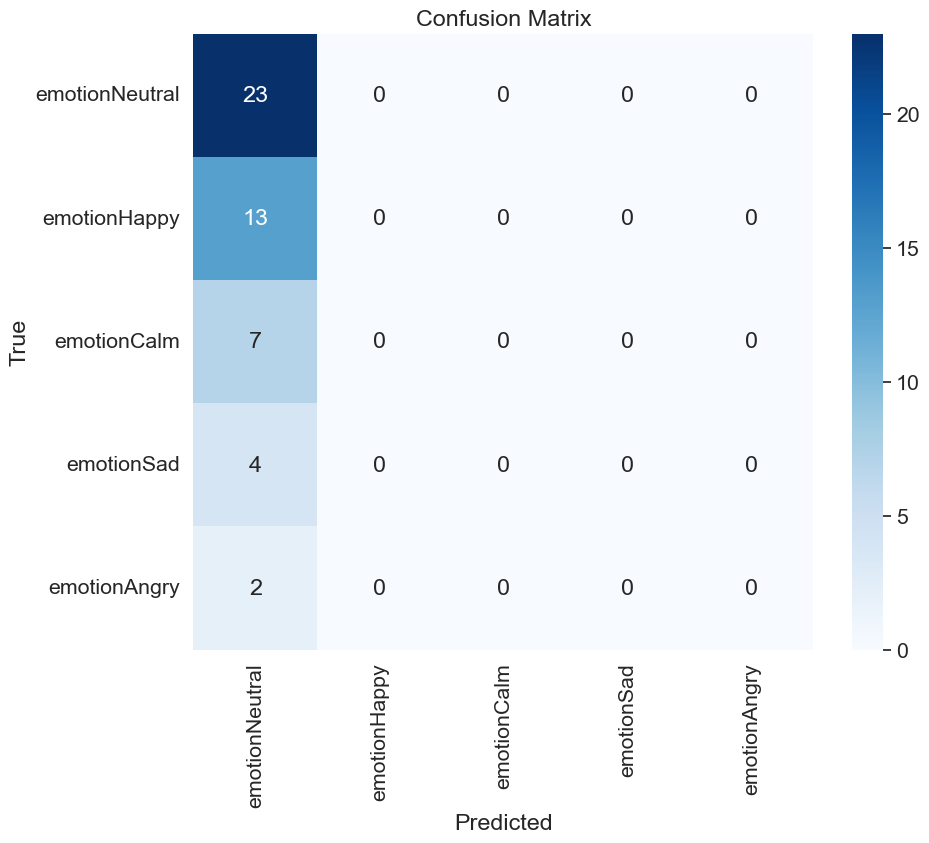

In [86]:
# Print class distribution in the training set
print("Class distribution in Y_train:")
print(Y_train.sum(axis=0))

# Print class distribution in the test set
print("Class distribution in Y_test:")
print(Y_test.sum(axis=0))

# Print a sample of model predictions
Y_pred = model.predict(X_test_scaled)
Y_pred_classes = np.argmax(Y_pred, axis=1)
print("Sample predictions:", Y_pred_classes[:20])

# Ensure Y_test is a 1D array
Y_test_classes = np.argmax(Y_test.to_numpy(), axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [87]:
import pandas as pd

# Define the emotion mapping
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}

# Sample DataFrame
# df_fixed_all = pd.DataFrame({
#     'emotionIndex': ['N', 'H', 'C', 'S', 'A', 'N', 'H', 'C', 'S', 'A', 'N', 'H', 'C', 'S', 'A']
# })

# Count the occurrences of each emotion
emotion_counts = df_fixed_all['emotionIndex'].value_counts()

# Map the counts to emotion names
emotion_counts_named = emotion_counts.rename(index=emotion_mapping)

# Print the counts
print(emotion_counts_named)

emotionNeutral    120
emotionHappy       36
emotionSad         32
emotionCalm        31
emotionAngry       24
Name: emotionIndex, dtype: int64


In [88]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Convert labels to one-hot encoding
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}


label_fixed_one_hot = pd.get_dummies(df_fixed_all.emotionIndex.map(emotion_mapping))

# Define the number of input features
input_shape = (len(key_features),)

# Define the number of output classes (emotions)
num_classes = label_fixed_one_hot.shape[1]

# Define the model
model = keras.models.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(layers.Dense(int(input_shape[0] * 0.8), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.6), activation="relu"))
model.add(layers.Dense(int(input_shape[0] * 0.1), activation="relu"))
model.add(layers.Dense(num_classes, activation="softmax"))  # Use softmax for multi-class classification

# Print the model summary
print(model.summary())

# Compile the model
model.compile(optimizer=keras.optimizers.SGD(0.01), loss="categorical_crossentropy", metrics=["accuracy"])

# Filter the DataFrame to include only the specified key features
data_keys = data_fixed_filter[key_features]

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(data_keys, label_fixed_one_hot, test_size=0.2)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
history = model.fit(X_train_scaled, Y_train, batch_size=32, epochs=100, validation_data=(X_test_scaled, Y_test))

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 8)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 5)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167 (668.00 B)

 Trainable params: 167 (668.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.1259 - loss: 1.6362 - val_accuracy: 0.3061 - val_loss: 1.6106
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3027 - loss: 1.6083 - val_accuracy: 0.3265 - val_loss: 1.6043
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4268 - loss: 1.5975 - val_accuracy: 0.3469 - val_loss: 1.5968
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4932 - loss: 1.5848 - val_accuracy: 0.3673 - val_loss: 1.5909
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4696 - loss: 1.5777 - val_accuracy: 0.3878 - val_loss: 1.5871
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4817 - loss: 1.5707 - val_accuracy: 0.3878 - val_loss: 1.5817
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5418 - loss: 1.5536 - val_accuracy: 0.3878 - val_loss: 1.5776
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5359 - loss: 1.5470 - val_accuracy: 0.3878 - val

In [89]:
# emotion count 

import pandas as pd

# Define the emotion mapping
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}

# Sample DataFrame
# df_fixed_all = pd.DataFrame({
#     'emotionIndex': ['N', 'H', 'C', 'S', 'A', 'N', 'H', 'C', 'S', 'A', 'N', 'H', 'C', 'S', 'A']
# })

# Count the occurrences of each emotion
emotion_counts = df_fixed_all['emotionIndex'].value_counts()

# Map the counts to emotion names
emotion_counts_named = emotion_counts.rename(index=emotion_mapping)

# Print the counts
print(emotion_counts_named)

emotionNeutral    120
emotionHappy       36
emotionSad         32
emotionCalm        31
emotionAngry       24
Name: emotionIndex, dtype: int64


In [90]:
# Map emotions to new column names
emotion_mapping = {
    'N': 'emotionNeutral',
    'H': 'emotionHappy',
    'C': 'emotionCalm',
    'S': 'emotionSad',
    'A': 'emotionAngry'
}

# Convert emotionIndex to one-hot encoding with specified column names
label_fixed_one_hot = pd.get_dummies(df_fixed_all.emotionIndex.map(emotion_mapping))

# Display the first few rows to verify
print(label_fixed_one_hot.head())

   emotionAngry  emotionCalm  emotionHappy  emotionNeutral  emotionSad
0             0            0             0               1           0
1             0            0             1               0           0
2             0            0             0               1           0
3             0            1             0               0           0
4             0            0             1               0           0


### Binary classification

In [91]:
## binary classification with XGBoost
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])

    print("Class " + label_dictionary[emotion_index + 1] + ":")
    label_fixed_binary = (label_fixed == emotion_index).astype(int)

    for i in range(10):
        model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='mlogloss', use_label_encoder=False)
        scores = model_selection.cross_validate(model, X=data_fixed_filter, y=label_fixed_binary, cv=10, n_jobs=1,
                                                scoring=['f1_micro', 'f1_macro', 'recall'])

        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])

    print(np.round(np.nanmean(f1_micro), 3), np.round(np.nanstd(f1_micro), 3))
    print(np.round(np.nanmean(f1_macro), 3), np.round(np.nanstd(f1_macro), 3))
    print(np.round(np.nanmean(recall), 3), np.round(np.nanstd(recall), 3))

    print()
    print()

Class N:
0.683 0.101
0.68 0.102
0.658 0.12


Class H:
0.844 0.071
0.637 0.144
0.358 0.286


Class C:
0.86 0.045
0.512 0.108
0.067 0.133


Class S:
0.848 0.05
0.576 0.108
0.2 0.163


Class A:
0.901 0.02
0.574 0.126
0.15 0.189


In [92]:
## binary classification with Random Forest
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])

    print("Class " + label_dictionary[emotion_index + 1] + ":")
    label_fixed_binary = (label_fixed == emotion_index).astype(int)

    for i in range(10):
        model = RandomForestClassifier(n_estimators=200, max_depth=5, class_weight={0: 0.1, 1: 1})
        scores = model_selection.cross_validate(model, X=data_fixed_filter, y=label_fixed_binary, cv=10, n_jobs=1,
                                                scoring=['f1_micro', 'f1_macro', 'recall'])

        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])

    print(np.round(np.nanmean(f1_micro), 3), np.round(np.nanstd(f1_micro), 3))
    print(np.round(np.nanmean(f1_macro), 3), np.round(np.nanstd(f1_macro), 3))
    print(np.round(np.nanmean(recall), 3), np.round(np.nanstd(recall), 3))

    print()
    print()

Class N:
0.577 0.074
0.496 0.117
0.961 0.055


Class H:
0.848 0.057
0.62 0.135
0.278 0.223


Class C:
0.821 0.051
0.545 0.11
0.233 0.269


Class S:
0.802 0.12
0.619 0.135
0.377 0.204


Class A:
0.889 0.032
0.561 0.134
0.217 0.333


In [93]:
## binary classification with SVM
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])

    print("Class " + label_dictionary[emotion_index + 1] + ":")
    label_fixed_binary = (label_fixed == emotion_index).astype(int)

    for i in range(10):
        model = SVC(kernel='rbf', decision_function_shape='ovr', probability=True)
        scores = model_selection.cross_validate(model, X=data_fixed_filter, y=label_fixed_binary, cv=10, n_jobs=1,
                                                scoring=['f1_micro', 'f1_macro', 'recall'])

        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])

    print(np.round(np.nanmean(f1_micro), 3), np.round(np.nanstd(f1_micro), 3))
    print(np.round(np.nanmean(f1_macro), 3), np.round(np.nanstd(f1_macro), 3))
    print(np.round(np.nanmean(recall), 3), np.round(np.nanstd(recall), 3))

    print()
    print()

Class N:
0.669 0.112
0.648 0.128
0.542 0.259


Class H:
0.852 0.019
0.46 0.006
0.0 0.0


Class C:
0.872 0.011
0.466 0.003
0.0 0.0


Class S:
0.868 0.014
0.465 0.004
0.0 0.0


Class A:
0.902 0.019
0.474 0.005
0.0 0.0



### Predicting values that have been created externally (not part of emotion prediction project)

In [94]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# import pickle
# 
# # Load the CSV file
# df = pd.read_csv('data/fixed_dummy_dataset.csv')
# 
# # Check if 'emotionIndex' exists in the DataFrame
# if 'emotionIndex' not in df.columns:
#     raise KeyError("'emotionIndex' column is missing from the DataFrame")
# 
# # Select a single row (for example, the first row for simplicity)
# sample_row = df.iloc[0:1]
# 
# # Preprocess the sample_row
# # Convert categorical features into numerical features
# sample_row.loc[:, 'gender'] = (sample_row['gender'] == 'Male').astype(int)
# sample_row.loc[:, 'ageRange'] = sample_row['ageRange'].map({'16-19': 1, '20-29': 2, '30-39': 3, '>=50': 4})
# sample_row.loc[:, 'degree'] = sample_row['degree'].map({'High School': 1, 'College/University': 2})
# sample_row.loc[:, 'pcTimeAverage'] = sample_row['pcTimeAverage'].map({'less than an hour per day': 1, 'between 1 hour and 3 hours per day': 2, 'More than 3 hours per day': 3})
# sample_row.loc[:, 'status'] = sample_row['status'].map({'Student': 1, 'Professional': 2})
# sample_row.loc[:, 'typeWith'] = sample_row['typeWith'].map({'1 hand': 1, '2 hands': 2})
# 
# # Check if 'country' and 'typistType' columns exist before creating dummies
# if 'country' in sample_row.columns and 'typistType' in sample_row.columns:
#     sample_row = pd.get_dummies(sample_row, columns=['country', 'typistType'])
# else:
#     print("Columns 'country' and/or 'typistType' do not exist in the DataFrame.")
# 
# print("now df: ", sample_row)
# 
# # Assuming 'emotionIndex' is the label column in your CSV
# if 'emotionIndex' not in sample_row.columns:
#     raise KeyError("'emotionIndex' column is missing from the sample_row DataFrame")
# 
# actual_emotion = sample_row['emotionIndex'].values[0]  # Save the actual emotion for comparison
# sample_row = sample_row.drop('emotionIndex', axis=1)  # Drop the label column for prediction
# 
# print("after dropping emotion:", sample_row)
# 
# # Scale the data
# scaler = MinMaxScaler()
# sample_row_scaled = scaler.fit_transform(sample_row)
# 
# # Load your model
# with open('model.pkl', 'rb') as file:
#     model = pickle.load(file)
# 
# # Predict the emotion
# predicted_emotion = model.predict(sample_row_scaled)
# 
# # Print out the predicted and actual emotion for comparison
# print(f"Predicted Emotion: {predicted_emotion}")
# print(f"Actual Emotion: {actual_emotion}")

In [95]:
# note to self: you first have to conduct a cell running the iterate all method, to save model correctly
# Predict the emotion from a CSV file
for model in model_names:
    predictions = predict_emotion('data/fixed_dummy_dataset.csv', f'{model}.pkl')
    print(predictions)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
[[0.05524344 0.57528911 0.22727649 0.07898331 0.06320765]
 [0.1189463  0.57614026 0.15745107 0.09470526 0.05275711]
 [0.38444032 0.09096442 0.18097676 0.16592143 0.17769706]]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[[0.34938822 0.4107894  0.16488392 0.04145266 0.0334858 ]
 [0.36746862 0.173425   0.11080055 0.27134699 0.07695885]
 [0.3865756  0.1534022  0.15281614 0.22941736 0.0777887 ]]
<class 'xgboost.sklearn.XGBClassifier'>
[[0.19270457 0.74520844 0.04291929 0.0142404  0.00492726]
 [0.3751317  0.02409682 0.02993781 0.554023   0.01681064]
 [0.89133483 0.00915005 0.06418351 0.02323172 0.01209992]]
<class 'sklearn.svm._classes.SVC'>
[[0.50042689 0.15649093 0.10748796 0.11601832 0.1195759 ]
 [0.52530455 0.15050039 0.09725258 0.10951266 0.11742981]
 [0.52551865 0.14543884 0.10800239 0.10590505 0.11513507]]
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
[[5.55283768e-02 8.50007247e-01 3.840

In [96]:
#predict real csv
# Save the first 5 rows of the dataframe `data_fixed` to a CSV file
data_fixed.head(5).to_csv('data/data_fixed_first_5_rows.csv', index=False)

In [97]:
for model in model_names:
    predictions = predict_emotion('data/data_fixed_first_5_rows.csv', f'{model}.pkl')
    print(predictions)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
[[0.20170004 0.51646999 0.18190194 0.07755599 0.02237203]
 [0.096337   0.78566267 0.02648271 0.03357898 0.05793864]
 [0.04294992 0.15839213 0.69763468 0.05085544 0.05016784]
 [0.06058967 0.38265129 0.29409215 0.23097652 0.03169036]
 [0.05183512 0.35879301 0.39896824 0.1155074  0.07489623]]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
[[0.33670673 0.20799478 0.08699161 0.34111838 0.0271885 ]
 [0.51435854 0.32242812 0.05144166 0.10039273 0.01137895]
 [0.34199424 0.19565418 0.19302384 0.19988461 0.06944313]
 [0.28617476 0.22797619 0.19506957 0.22793985 0.06283963]
 [0.3618756  0.38829505 0.14971679 0.04344113 0.05667143]]
<class 'xgboost.sklearn.XGBClassifier'>
[[0.7862319  0.02162216 0.00414759 0.17579454 0.01220394]
 [0.55182177 0.40995622 0.00671701 0.02756608 0.00393892]
 [0.928886   0.01672589 0.03099225 0.01912682 0.00426898]
 [0.19898753 0.11078628 0.02906393 0.6522059  0.00895636]
 [0.01567041 0.9785073  0.00

## Feature importance

In [98]:
# data standardization
scaler = MinMaxScaler()
data_fixed = pd.DataFrame(scaler.fit_transform(data_fixed), columns=data_fixed.columns)

#### Chi-squared

In [99]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

demo_features = np.array(
    ['typeWith', 'gender', 'ageRange', 'degree', 'pcTimeAverage', 'status', 'country', 'typistType'])

# Feature extraction
test = SelectKBest(score_func=chi2, k=8)
fit = test.fit(data_fixed.loc[:, demo_features].fillna(100).replace(-1, 16),
               pd.cut(data_fixed.D1U2_mean.fillna(0), bins=[0, 372, 445, 573, 4306], labels=[1, 2, 3, 4]).fillna(1))

# Summarize scores
np.set_printoptions(precision=3)
print("Ordered features by importance with their corresponding chi2 score")
print(demo_features[np.argsort(fit.scores_)][::-1])
print(fit.scores_[np.argsort(fit.scores_)][::-1])

KeyError: "['country', 'typistType'] not in index"

#### Correlation coefficients

In [ ]:
importances = data_fixed.apply(lambda x: x.corr(data_fixed.D1U2_mean))
indices = np.argsort(importances)
indices_abs = np.argsort(np.abs(importances))[::-1]
print(importances[indices_abs])

In [ ]:
plt.figure(figsize=(10, 10))
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), importances[indices].index.values)
plt.xlabel('Relative Importance')
plt.show()

#### Information Gain

In [ ]:
from info_gain import info_gain

importances_ig = []
for col in data_fixed.columns:
    importances_ig.append(info_gain.info_gain(data_fixed[col], data_fixed.D1U2_mean))
indices_ig = np.argsort(importances_ig)[::-1]
pd.concat([pd.Series(data_fixed.columns[indices_ig]), pd.Series(np.sort(importances_ig)[::-1])], axis=1).set_index(0)

#### Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(data_fixed, data_fixed.D1U2_mean)
mi = pd.Series(mi)
mi.index = data_fixed.columns
mi.sort_values(ascending=False)
mi.sort_values(ascending=False).plot.bar(figsize=(10, 4))

#### Recursive Feature Elimination (RFE)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
rfe = RFE(model, 1)
fit = rfe.fit(data_fixed, label_fixed)

print("Feature Ranking: %s" % fit.ranking_)

In [ ]:
list(data_fixed.columns[fit.ranking_ - 1])

#### SHAP values

In [ ]:
# DF, based on which importance is checked
X_importance = pd.DataFrame(data_fixed, columns=data_fixed.columns)

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance, max_display=len(data_fixed.columns))

#### RF feature importance

In [ ]:
# fixing RF feature importance

import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(model, feature_names):
    """
    Plots the feature importance of a trained Random Forest model.
    
    Parameters:
    - model: The trained Random Forest model.
    - feature_names: A list of names corresponding to the features used by the model.
    """
    # Get the feature importances from the model
    importances = model.feature_importances_
    
    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Rearrange the feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]
    
    # Create a bar chart
    plt.figure(figsize=(10, 8))
    plt.title("Feature Importance")
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), names)
    plt.xlabel('Relative Importance')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.show()


with open('RF.pkl', 'rb') as file:
    model = pickle.load(file)

plot_feature_importance(model, data_fixed.columns.tolist())

In [ ]:
best_model = 'RF'
X_train, X_test, Y_train, Y_test = train_test_split(data_fixed, label_fixed, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = classifiers[classifiers_name.index(best_model)]
model.fit(X_train, Y_train)

performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
plot_confusion_matrix(performance_metrics["Confusion Matrix"])

In [ ]:
plt.figure(figsize=(10, 10))
pd.Series(model.feature_importances_, index=data_fixed.columns).nlargest(data_fixed.shape[1])[::-1].plot(kind='barh')
plt.show()

#### XGB feature importance

In [ ]:
best_model = 'XGB'
X_train, X_test, Y_train, Y_test = train_test_split(data_fixed, label_fixed, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = classifiers[classifiers_name.index(best_model)]
model.fit(X_train, Y_train)

performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
plot_confusion_matrix(performance_metrics["Confusion Matrix"])

In [ ]:
plt.figure(figsize=(10, 10))
pd.Series(model.feature_importances_, index=data_fixed.columns).nlargest(data_fixed.shape[1])[::-1].plot(kind='barh')
plt.show()